In [1]:
# Automated analysis routines to measure AP metrics
# copyright © 2022, Bum-Rak Choi, Taeyun Kim, Allison Navarrete-Welton
# This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [2]:
#Load libraries
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as pe
from netCDF4 import Dataset 
import cv2 as cv
import sklearn
from skimage import filters

import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import netcdf
from scipy.ndimage import gaussian_filter

In [3]:
#Set plotting aesthetics  
pal = sns.color_palette('colorblind')
sns.set_palette(pal)
sns.set_style('white')

In [4]:
#Load sample data
filename = 'sample_data/2021-07-30-060.nc'
fid = Dataset(filename,'r')
temp = fid.variables['Data']
data60 = temp[:]*1
fid.close()

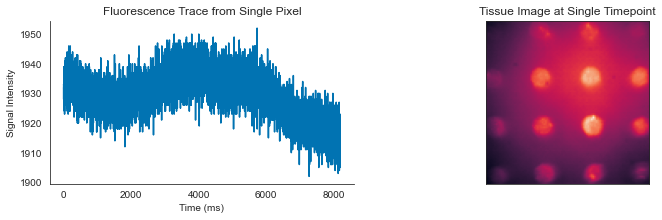

In [5]:
#Plot fluorescence signal at single pixel over time
test_trace = data60[:, 550]
plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
plt.plot(test_trace)
plt.title("Fluorescence Trace from Single Pixel")
plt.xlabel("Time (ms)")
plt.ylabel("Signal Intensity")
sns.despine()

#Plot tissue image at single timepoint
test_img = data60[50,:-2].reshape(100,100)
plt.subplot(1,2,2)
plt.imshow(test_img)
plt.xticks([])
plt.yticks([])
plt.title("Tissue Image at Single Timepoint")
plt.show()

# Image Thresholding & Spheroid Labeling

In [6]:
class AutoThr():
    '''
    A class to automatically detect and label spheroids from a cardiac microtissue spheroid image.
    Once made, the thresholded spheroid mask can be applied to subsequent time points.
    
    Attributes
    ----------
    raw_img: 2D array of floats
        raw image data
    thr_method: str
        Determines the image thresholding method applied. 
        Must be 'otsu', 'histogram', entropy', or 'cross_entropy'
    plot_mask: boolean
        if True, plot thresholded image with different colors for each labeled spheroid
    img: 2D array of floats (same dimensions as raw_img)
        image data rescaled to lie between (0,255)
    thr: int
        threshold value
    mask: 2D array of floats (same dimensions as raw_img)
        image mask with all spheroid regions set to 1 & background set to 0
    n_spheroids: int
        number of spheroids found
    spheroid_mask: 2D array of floats (same dimensions as raw_img)
        image mask with each spheroid labeled by a different index & background set to 0
    spheroid_pixel_groups: list of lists of floats
        pixel values grouped by spheroid
     
    Methods
    --------
    rescale_image(self, input_img = self.raw_img)
        Rescales image pixel values between 0 and 255
    smooth(self, arr, width)
        Smooths signal using boxcar averaging method (analogous to low pass filter)
    filter_histogram(self, h)
        Sets threshold value above histogram mode according to distribution shape.
        Reverts to Otsu filtering if histogram values are not amenable.
    calc_entropy_from_hist(self, h)
        Calculates entropy from a histogram distribution.
    calc_cross_entropy_from_hist(self, h, thr)
        Calculates cross entropy from a histogram distribution.
    set_mask(self, use_slide = False, thr_up  = None, thr_down = None)
        Make mask to threshold image based on preset thresholds. Can threshold
        below one upper threshold or between an upper and lower threshold.
    remove_small_pixels(self)
        Remove small pixel groups from mask using an erosion & dilation operation.
    get_spheroid_inds(self, plot_mask)
        Counts number of spheroids in mask and returns spheroid indices grouped by spheroid.
    get_spheroid_pixels(self)
        Gets all pixels from original image that correspond to each spheroid.
        Results stored in self.spheroid_pixel_groups 
    thr_pipeline(self):
        Thresholds image, finds spheroids, and labels pixels according to spheroid index
    apply_mask(self, new_img)
        Apply existing spheroid labeling mask to another image (ie, an image at a subsequent time point)
    '''
    
    def __init__(self, raw_img, thr_method = 'cross_entropy', plot_mask = True):
        self.raw_img = raw_img
        self.thr_method = thr_method
        self.plot_mask = plot_mask
        
        img_shape = np.shape(raw_img)
        self.pixel_inds = np.arange(img_shape[0]*img_shape[1])
        
    def rescale_image(self, img):
        '''
        Rescales image pixel values between 0 and 255
        
        Parameters 
        -----------
        input_img: 2D float array
            raw image data. Default is the self.raw_img used for thresholding but 
            can be applied to images from subsequent timepoints
        '''
        img_min = img.min()
        self.img = 255*np.array((img-img_min)/(img.max()-img_min))
        return 

    def smooth(self, arr, width):
        '''
        Smooths signal using boxcar averaging method (analogous to low pass filter)
        
        Parameters
        -----------
        arr: 1D array of floats
            signal data
        width: int
            window size over which to smooth
            
        Returns
        --------
        smooth_arr: 1D array of floats
            smoothed signal
        '''
        #ensure width is an even integer
        if width%2 == 0:
            width = width + 1 
        
        #take average along sequential windows
        half_width = int(width / 2)
        new_arr = [np.sum(arr[int(i - half_width):int(i + half_width + 1)]) 
                   for i in np.arange(half_width, len(arr)-width)]
        new_arr = np.array(new_arr) / (width - 1)
        
        #concatenate with original data at array edges
        smooth_arr = np.concatenate([arr[:half_width], new_arr, arr[int(len(arr)-width):]])
        return smooth_arr

    def calc_entropy_from_hist(self, h):
        '''
        Calculates entropy from a histogram distribution.
        
        Parameters
        -----------
        h: 1D array of ints
            partial histogram distribution from image pixel values
            
        Returns
        -------
        entropy: float
            entropy value
        '''
        positive_inds = np.where(h >= 1)
        h_sum = np.sum(h)
        res = np.zeros(len(h))
        if np.any(positive_inds):
            p = h[positive_inds]/h_sum
            res[positive_inds] = -p*np.log(p)
        entropy = res.sum()
        return entropy

    def calc_cross_entropy_from_hist(self, h, thr):
        '''
        Calculates cross entropy from a histogram distribution.
        
        Parameters
        -----------
        h: 1D array of ints
            partial histogram distribution from image pixel values
        thr: int
            index to divide the histogram 
            
        Returns
        -------
        cross_entropy: float
            cross entropy value
        '''
        h1 = np.array(h[0:thr])
        h2 = np.array(h[thr:])
        h1_total = np.sum(h1)
        h2_total = np.sum(h2)
        q1 = h1_total/(h1_total + h2_total)
        q2 = 1 - q1
        positive_ind1 = np.where(h1 >= 1)
        positive_ind2 = np.where(h2 >= 1)

        res1 = np.zeros(len(h1))
        if np.any(positive_ind1): 
            p = h1[positive_ind1]/h1_total
            res1[positive_ind1] = -p*np.log(p) + p*np.log(q1)

        res2 = np.zeros(len(h2)) 
        if np.any(positive_ind2):
            p = h2[positive_ind2]/h2_total
            res2[positive_ind2] = -p*np.log(p) + p*np.log(q2)
            
        cross_entropy = np.sum(res1) + np.sum(res2)

        return cross_entropy
    
    def filter_histogram(self, h):
        '''
        Sets threshold value above histogram mode according to distribution shape.
        Reverts to Otsu filtering if histogram values are not amenable.
        
        Parameters
        ----------
        h: 1D array of ints, size 255
            histogram distribution of pixel values
            
        Returns
        --------
        thr: int
            threshold value
        '''
        #smooth & filter histogram 
        h_smooth = self.smooth(h, 17)
        h_filtered = scipy.ndimage.gaussian_filter1d(h_smooth, sigma = 11, order = 1)

        #Find local max above which to filter
        ind_max = np.argmax(h_smooth)
        h_max = h_smooth[ind_max] 

        #if local max index is >240, use Otsu thresholding instead
        if ind_max > 240:
            thr = filters.threshold_otsu(hist = h)
            print("Hist thresholding error- max in h_smooth is too large-- using Otsu")        

        #Set histogram threshold to 20% of maximum or 2, whichever is higher
        if h_max*0.05 > 2:
            h_thr = h_max*0.2
        else:
            h_thr = 2

        #set initial threshold to first index above ind_max where histogram values decrease
        #below h_thr
        iB = np.where(h_smooth[ind_max:] < h_thr)
        if np.any(iB):
            thr = iB[0][0] + ind_max
            #adjust threshold to next non-zero value of filtered histogram 
            i_min = np.where(h_filtered[thr:] >= 0)
            if np.any(i_min):
                thr += i_min[0][0]
            else:
                thr = filters.threshold_otsu(hist = h)
                print("Hist thresholding error- threshold set over derivative-- using Otsu")      
        else:
            thr = filters.threshold_otsu(hist = h)
            print("Hist thresholding error- no values less than threshold- using Otsu")  
        return thr
        
    def auto_threshold(self):
        '''
        Finds threshold value according to method specified by self.thr_method.
        Result stored in self.thr
        '''
        h = np.histogram(self.img, range = (0,255), bins = 255)[0]
        
        if self.thr_method == 'otsu':
            thr = filters.threshold_otsu(hist = h, nbins = 255)
        elif self.thr_method == 'hist':
            thr = self.filter_histogram(h)
        else:
            i_start, i_end = 10, 220
            h_elements = np.zeros(len(h))
            for i in range(i_start, i_end):
                if self.thr_method == 'entropy':
                    h_elements[i] = self.calc_entropy_from_hist(h[:i]) + self.calc_entropy_from_hist(h[i+1:])
                elif self.thr_method == 'cross_entropy':
                    h_elements[i] = self.calc_cross_entropy_from_hist(h, i)
                else:
                    print("Error: No such thresholding method exists")
            thr = np.argmax(h_elements)
        self.thr = thr
        return

    def set_mask(self, use_slide = False,
                thr_up  = None, thr_down = None):
        '''
        Makes mask to threshold image based on preset thresholds. Can threshold
        below one upper threshold or between an upper and lower threshold.
        Results stored in self.mask.
        
        Parameters 
        -----------
        use_slide: boolean
            if True, remove pixels between a lower threshold and upper threshold
            if False, remove all pixels below threshold
        thr_up: int
            upper threshold when use_slide = True
        thr_down: int
            lower threshold when use_slide = True 
        '''
        if use_slide:
            below_thr = np.asarray((self.img >= thr_up)+(self.img < thr_down)).nonzero()
        else:
            below_thr = np.asarray(self.img <= self.thr).nonzero()
            
        mask = np.ones(self.img.shape)
        if np.any(below_thr):
            n = len(below_thr[0])
            if n > 0:
                mask[below_thr] = 0     
        self.mask = mask.astype(int)
        return 
    
    def remove_small_pixels(self):
        '''
        Removes small pixel groups from mask using an erosion & dilation operation.
        Results stored in self.mask
        '''
        #Ensure datatype compatibility with OpenCV
        mask = self.mask.astype('float64')

        #Erosion & dilation
        self.mask = cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones([3,3])).reshape(mask.shape)
        return

    def get_spheroid_inds(self):
        '''
        Counts number of spheroids in mask and returns spheroid indices grouped by spheroid.
        Number of spheroids stored in self.n_spheroids
        Mask with spheroids labeled by separate indices is stored in self.spheroid_mask
        '''
        s = np.array([[1,1,1],[1,1,1], [1,1,1]])  #include diagonally-touching points in spheroids 
        spheroid_mask, n_spheroids = scipy.ndimage.label(self.mask, structure = s)
        
        self.n_spheroids = n_spheroids
        self.spheroid_mask = spheroid_mask
    
        if self.plot_mask:
            plt.imshow(spheroid_mask)
            plt.colorbar()
            plt.title("Spheroids: n = " + str(n_spheroids))
        return 

    def get_spheroid_pixels(self, input_img, store = True):
        '''
        Gets all indices and pixels from original image that correspond to each spheroid.
        Results stored in self.spheroid_pixel_groups
        
        Parameters 
        -----------
        input_img: 
            2D image data rescaled to lie between (0,255)
        
        Returns
        --------
        spheroid_pixel_groups
        '''
        flat_mask = self.spheroid_mask.reshape(-1,)
        region_labels = np.unique(flat_mask)
        spheroid_pixel_groups = [input_img[self.spheroid_mask == n] for n in region_labels if n > 0 ]
        spheroid_ind_groups = [self.pixel_inds[np.nonzero([flat_mask == n])[1]] for n in region_labels if n > 0]
        
        if store:
            self.spheroid_pixel_groups = spheroid_pixel_groups
            self.spheroid_ind_groups = spheroid_ind_groups
        return spheroid_pixel_groups, spheroid_ind_groups
    
    def thr_pipeline(self):
        '''
        Thresholds image, finds spheroids, and labels pixels according to spheroid index.
        Pixel groups stored in self.spheroid_pixel_groups
        Labeled spheroid mask stored in self.spheroid_mask 
        '''
        img = self.rescale_image(self.raw_img)
        self.auto_threshold()
        self.set_mask()
        self.remove_small_pixels()
        spheroid_inds = self.get_spheroid_inds()
        pixel_groups = self.get_spheroid_pixels(self.img)
        return 


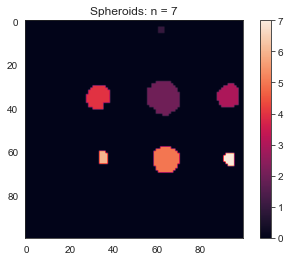

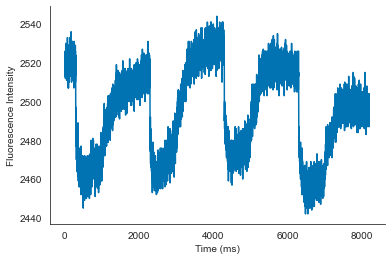

In [7]:
#Auto threshold the sample frame
auto_thr = AutoThr(raw_img = test_img, thr_method = 'entropy')
auto_thr.thr_pipeline()

#Separate signal traces from individual spheroids
spheroid_group_inds = auto_thr.spheroid_ind_groups
spheroids_data = [[data60[:,ind] for ind in spheroid_inds] for spheroid_inds in spheroid_group_inds]

#Plot spheroid masking result
plt.imshow(auto_thr.spheroid_mask)

#Plot fluorescence signal trace from sample point in an identified spheroid
plt.figure()
plt.plot(data60[:,spheroid_group_inds[0][0]])
plt.xlabel("Time (ms)")
plt.ylabel("Fluorescence Intensity")
sns.despine()

# Identify Spheroids with True Action Potentials Using FFP

In [8]:
class FFT_GoodSpheroids():
    '''
    Class to identify spheroids with action potentials from a set of 
    previously thresholded spheroid regions. Action potentials are 
    identified using FFT. Bad spheroids are discarded. 
    Of the good spheroids, only the pixels with APs are returned.
    
    
    Attributes 
    -----------
    spheroids: list of list of 1D arrays of floats   
        signal fluorescence data from multiple pixels, grouped by spheroid
    f_scan_int: int
        rescaling parameter #TODO: why is this needed?
    fft_win: list of floats of length 2
        sets spectral window to consider
    bad_thresh: float
        minimum percent of pixels per spheroid that must lack APs for spheroid to be 
        discarded
    hamming: boolean
        determines whether or not to apply a Hamming window before calculating FFT
    
    
    Methods
    --------
    calc_FFT_dom_all(self)
        Caculates the FFT of a fluorescence signal trace & returns dominant frequency
    check_spheroid(self, data)
        Determines if a signal trace has action potentials
    identify_good_spheroids(self):
        Identifies spheroids with enough action potentials and returns data from 
        all pixels with action potentials from these high-quality spheroids
    '''
    
    def __init__(self, spheroids  = None, f_scan_int  = 1, fft_win = [0.2, 10], bad_thresh = 0.2,
                hamming = False):
        self.spheroids = spheroids
        self.f_scan_int = f_scan_int
        self.fft_win = fft_win
        self.bad_thresh = bad_thresh
        self.hamming = hamming
        
    def calc_FFT_dom_all(self, data):
        '''
        Caculates the FFT of a fluorescence signal trace & returns dominant frequency.
        Hamming window may be used to improve frequency selection by 
        reducing spectral leakage due to non-infinite signal.
        
        Attributes
        -----------
        data: 1D array of floats
            signal fluorescence data from one pixel
            
        Returns 
        --------
        ind_max: int
            index in Fourier-space within FFT window of the dominant frequency
        bandwidth: float
            bandwidth of FFT spectrum #TODO: check this equation, looks like a variance estimate?
        
        '''
        n_frame = np.size(data)
        a_fft = np.zeros(n_frame)
        
        #rescale x axis to lie in (0, 1000/f_scan_int) range 
        #TODO: why this way...
        f_res = 1000/(n_frame*self.f_scan_int)
        x_fft = np.arange(n_frame)*f_res 
        
        #select x values within the FFT window
        hz_max_ind = int(self.fft_win[1]/f_res)
        hz_min_ind = int(self.fft_win[0]/f_res)
        x = x_fft[hz_min_ind:hz_max_ind]
        
        #find maximum frequency within FFT window
        if self.hamming: #NOTE: IDL used this but it doesn't help for my method
            hamming_window = np.hamming(n_frame)   
            a_fft = np.fft.fft(data*hamming_window) 
        else:
            a_fft = np.fft.fft(data)
        power_spectrum = np.abs(a_fft[hz_min_ind:hz_max_ind])**2
        ind = np.argmax(power_spectrum)
        f_max = power_spectrum[ind]

        #set indicator action potentials exist
        if ind <= 1:
            ind_max = -1
            sum_fft = -1
            bandwidth = -1
        else:
            ind_max = x[ind]
            sum_fft = np.sum(power_spectrum)
            
            #original IDL implementation, not sure why written this way
            bandwidth =  np.sqrt(np.sum(power_spectrum*x**2)/sum_fft - (np.sum(power_spectrum*x)/sum_fft)**2)
            #this is the variance
            #bandwidth = np.sqrt(np.sum((power_spectrum*x/sum_fft)**2) - (np.sum(power_spectrum*x)/sum_fft)**2)

        return ind_max, bandwidth
    
        
    def check_spheroid(self, data):
        '''
        Determines if a signal trace has action potentials
        
        Parameters
        -----------
        data: 1D array of floats
            fluorescence signal trace
        
        Returns
        --------
        no_APs: boolean
            True if signal has no action potentials 
        '''
        ind_max, bandwidth = self.calc_FFT_dom_all(data)
        #TODO: find where in IDL they use this to filter out bad spheres
        #TODO: if we use my method, can get rid of bandwidth calculations (never used)
        if ind_max == -1:
            no_APs = 1
        else:
            no_APs = 0
        return no_APs
        
    
    def rescale_trace(self, trace):
        '''
        Rescales trace values between 0 and 100
        
        Parameters 
        -----------
        trace: 1D float array
            raw fluorescence signal trace
            
        Returns
        --------
        rescaled_trace: 1D float array
            fluorescences signal rescaled to lie between 0 and 100
        '''
        tr_min = trace.min()
        rescaled_trace = 100*np.array((trace - tr_min)/(trace.max() - tr_min)) 
        return rescaled_trace
    
    def average_traces(self, spheroid_traces):
        '''
        Averages traces per spheroid
        
        Parameters
        -----------
        spheroid_traces: list of list of 1D float arrays 
            holds one sub-list per spheroid where each sub-list contains
            all fluorescence signal traces that belong to that spheroid
        
        Returns
        --------
        averaged_spheroids: list of 1D float arrays
            holds one averaged signal trace per spheroid            
        '''
        #TODO: might be possible to do this faster if in array format
        averaged_spheroids = []
        for spheroid_tr in spheroid_traces:
            scaled_traces = np.mean([self.rescale_trace(trace) for trace in spheroid_tr], axis = 0)
            averaged_spheroids.append(-1*scaled_traces) #invert signal 
        return averaged_spheroids
    
    
    def identify_good_spheroids(self):
        '''
        Identifies spheroids with enough action potentials and returns one averaged
        trace per spheroid
        
        Returns
        --------
        averaged_traces: list of 1D float arrays
            one averaged trace per spheroid
        '''
        good_spheroids = []
        for spheroid in self.spheroids:
            no_AP_ct = 0
            pixels_with_APs = []
            for data in spheroid:
                no_APs = self.check_spheroid(data)
                no_AP_ct += no_APs
                if not no_APs:
                    pixels_with_APs.append(data)
            #Determine if spheroid is high quality
            if no_APs < np.size(spheroid)*self.bad_thresh:  
                good_spheroids.append(pixels_with_APs) 
                
        #Scale, invert, and average signals per spheroid       
        averaged_traces = self.average_traces(good_spheroids)
    
        return averaged_traces, good_spheroids

In [9]:
spher_filter = FFT_GoodSpheroids()
spher_filter.__init__(spheroids = spheroids_data, f_scan_int = 1)
all_traces, good_spheroids = spher_filter.identify_good_spheroids()
all_traces = [trace for trace in all_traces if np.sum(trace.shape) > 0]
    

# Remove Background Drift & Calculate dF/F 

In [10]:
class BaselineAdjALS:
    '''
    A class to remove baseline drift from a cardiac microtissue fluorescence signal 
    using asymmetric least squares smoothing inspired by Eleirs & Boelens, 2005. See 
    Baek et al, Analyst 2015, 140, 251-252.
    
    
    Attributes
    -----------
    f_lambda: float
        weight parameter that balances the first (fitness to data) and second (smoothness)
        terms in the regularized least squares function 
    fp: float
        asymmetry parameter (recommended to set between 0.001-0.01)
    i_iter: int
        number of iterations to minimize cost function
    n_max: int
        maximum length of signal on which to search for baseline
    plot: Boolean
        determines whether or not to plot sequential fitting of baseline

    Methods
    --------
    smooth(self, arr, width)
        Smooths signal using boxcar averaging method (analogous to low pass filter)
    make_second_diff_matrix(self, n)
        makes 2nd difference matrix
    baseline_adjust(self, inputs)
        Calculates baseline and subtracts it from fluorescence signal
    '''
    
    def __init__(self, f_lambda = 1, fp = 0.01, i_iter = 10, n_max = 124, plot = True,
                fig_name = 'figures/test.png'):
        self.f_lambda = f_lambda
        self.fp = fp
        self.i_iter = i_iter
        self.n_max = n_max
        self.plot = plot
        self.fig_name = fig_name
        
    def smooth(self, arr, width):
        '''
        Smooths signal using boxcar averaging method (analogous to low pass filter)
        
        Parameters
        -----------
        arr: 1D array of floats
            signal data
        width: int
            window size over which to smooth
            
        Returns
        --------
        smooth_arr: 1D array of floats
            smoothed signal
        '''
        #ensure width is an even integer
        if width%2 == 0:
            width = width + 1 
        
        #take average along sequential windows
        half_width = int(width / 2)
        new_arr = [np.sum(arr[int(i - half_width):int(i + half_width + 1)]) 
                   for i in np.arange(half_width, len(arr)-width)]
        new_arr = np.array(new_arr) / width
        
        #concatenate with original data at array edges
        smooth_arr = np.concatenate([arr[:half_width], new_arr, arr[int(len(arr)-width):]])
        return smooth_arr
        
    def make_second_diff_matrix(self, n):
        '''
        Makes second difference matrix
        
        Parameters
        -----------
        n: int
            matrix dimension
        
        Returns
        --------
        d: 2D array
            second difference matrix
        '''
        dn = np.ones(n)
        dn[0] = 0
        dn1 = np.ones(n-1)*-2
        dn1[0] = -1
        dn2 = np.ones(n-2)
        d_combine = np.concatenate([dn, dn1, dn2])
        d_index_x = np.concatenate([np.arange(n), np.arange(n-1), np.arange(n-2)])
        d_index_y = np.concatenate([np.arange(n), np.arange(n-1)+1, np.arange(n-2)+2])
        d = csr_matrix((d_combine, (d_index_x, d_index_y))).toarray()
        
        return d 
        
        
    def make_asl_matrix(self, lamda, w):
        '''
        Makes matrix terms that are part of the solution to the 
        minimization of the weighted least squares equation. 
        
        Parameters
        -----------
        lamda: float
            factor that balances smoothness and data fit
        w: 1D array of floats
            weight vector
        
        Returns
        --------
        lamda_d_gram: 
            Gram matrix of 2nd difference matrix multiplied by lamda
        A: 2D array
            inverse of lamda_d_gram + weight matrix, component of the 
            solution to the least squares equation minimization
        weights: 2D array
            diagonal matrix of weights
        '''
        n = np.size(w)  
        i = np.arange(n)
        weights = csr_matrix((w, (i,i)), shape = (n,n)).toarray()
        d = self.make_second_diff_matrix(n)
        d_gram = np.matmul(d, d.transpose()) #Gram matrix of 2nd difference matrix
        lamda_d_gram = d_gram*lamda        
        A = np.linalg.inv(weights + lamda_d_gram)
        return A, weights
        
    def baseline_ASL_iter(self, lamda, p, y_res, i_iter):
        '''
        Solves minimization problem of weighted least squares equation with
        repeated updates to weight parameters that remove signal peaks, 
        producing a fit to the baseline of the signal.
        
        Parameters
        -----------
        lamda: float
            parameter that balances smoothness & data fit
        p: float
            asymmetry parameter (recommended to set between 0.001 and 0.1)
        y_res: 1D array
            signal data
        i_iter: int
            number of times to adjust the weight vector
        
        Returns
        --------
        baseline:  1D array
            signal baseline
        '''
        #constrain signal length to to n_max via resampling
        n_res = np.size(y_res)
        y = y_res
        if n_res > self.n_max:
            n = self.n_max
            y = y[::int(n_res/n)][:n]
            i_comp_flag = 1
        else:
            y = y_res
            n = n_res
            i_comp_flag = 0
            

        y = self.smooth(y, 10)  
        hold_y = y.copy()
        w = np.ones(n) 
        A, W_mat = self.make_asl_matrix(lamda, w) #A = W + lamda_d_gram
        baseline = np.matmul(np.matmul(A, W_mat), y)
        
        if self.plot:
            fig0, ax0 = plt.subplots(1,1,figsize = (9,4))
            sns.despine()
        save_xs, save_ys = [], []
        save_baselines = []
        
        if self.plot:
            ax0.plot(self.data, label = 'Original Signal', alpha = 1, linewidth = 0.5)
            ax0.plot(scipy.ndimage.interpolation.zoom(y, len(self.data)/len(y)), label = "Sampled Signal",
                     linewidth = 2)
            ax0.plot(scipy.ndimage.interpolation.zoom(baseline, len(self.data)/len(baseline)), label = "Iter 1",
                     linewidth = 2)
            save_baselines.append(scipy.ndimage.interpolation.zoom(baseline, len(self.data)/len(baseline)))
            
            
        #iterate to update weights and remove peaks from signal for fitting
        for i in range(i_iter):
            #AsLS method, requires optimizing lamda & p
            #weights are set near-zero in peak regions, found by comparing baseline & raw signal
            w = p*(y > baseline) + (1-p)*(y <= baseline) 
            
            #update A with new weights before re-solving
            A, W_mat = self.make_asl_matrix(lamda, w)
            baseline = np.matmul(np.matmul(A, W_mat), y)

            if self.plot:
                #Plot baselines
                interpoled_baseline = scipy.ndimage.interpolation.zoom(baseline, len(self.data)/len(baseline))
                ax0.plot(interpoled_baseline, label = "Iter " + str(i+2), linewidth =2)
                save_baselines.append(interpoled_baseline)
                
                #Plot function adjusted by weighted baseline
                idxs = np.where(y <= baseline)[0].tolist()
                scatter_ys = hold_y[idxs]
                scatter_xs = np.arange(len(y))[idxs]
                save_xs.append(scatter_xs)
                save_ys.append(scatter_ys)
                
        if self.plot:
            plt.xlabel("Time (ms)")
            plt.ylabel("Fluorescence Intensity")
            sns.despine()
            plt.tight_layout()
            ax0.legend(loc = 'right')
            ax0.set_title("Iterative Baseline Fits")
            ax0.set_xlim(0,11000)

        #interpolate to resize baseline-smoothed signal to original signal length
        if i_comp_flag == 1:
            baseline = scipy.ndimage.interpolation.zoom(baseline, n_res/len(baseline))
        return baseline, [save_xs, save_ys, y, self.data, save_baselines]
    
    def baseline_adjust(self, inputs):
        '''
        Calculates baseline and subtracts it from fluorescence signal
        
        Parameters
        -----------
        inputs: 1D array
            fluorescence signal
            
        Returns
        --------
        baseline_subtract: 1D array
            fluorescence signal with baseline subtracted
        '''
        self.data = inputs
        baseline, to_plot = self.baseline_ASL_iter(self.f_lambda, self.fp, inputs, self.i_iter)        
        baseline_subtract = -inputs/baseline
        return baseline_subtract, to_plot

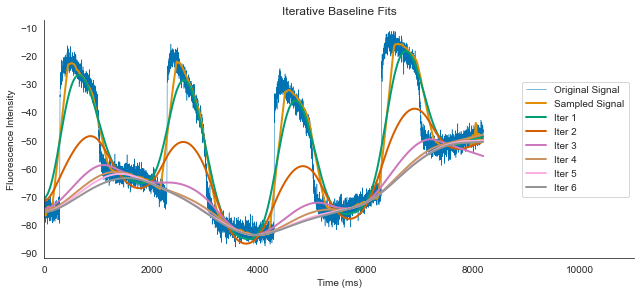

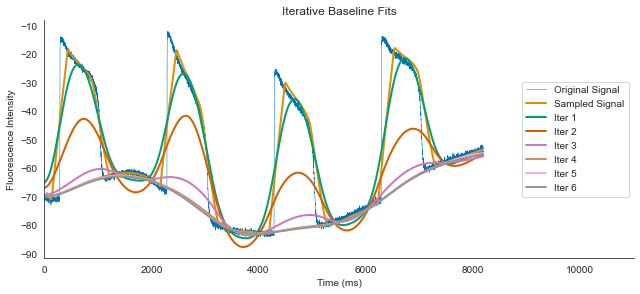

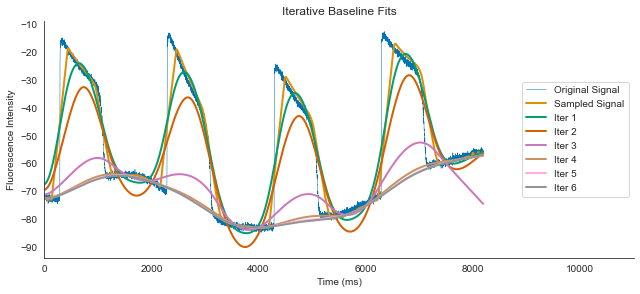

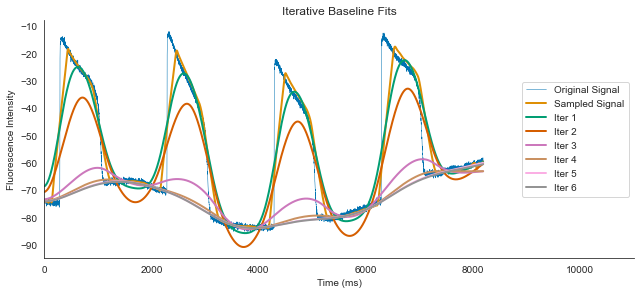

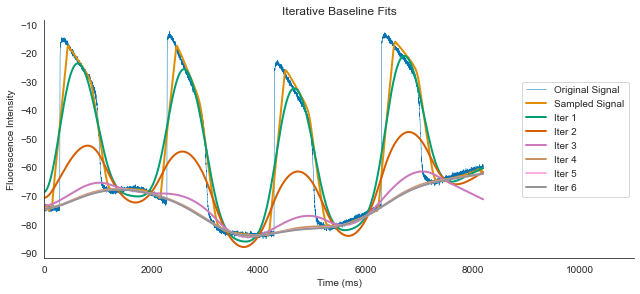

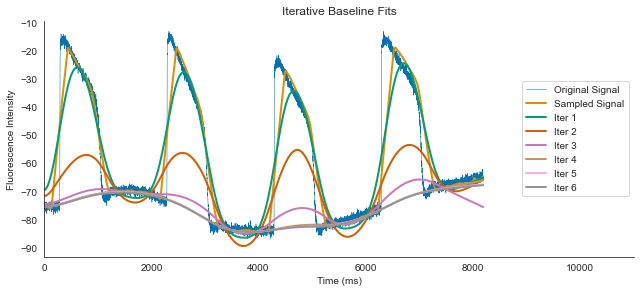

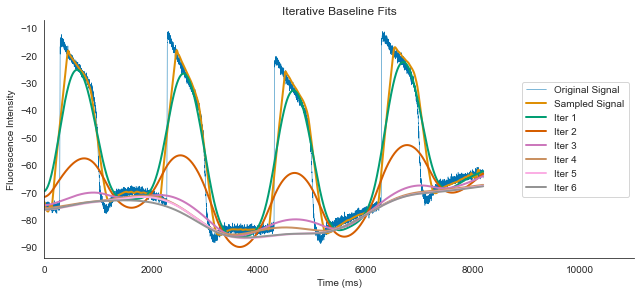

In [11]:
#Adjust baseline to remove background drift from all traces in sample image
base = BaselineAdjALS()
base.__init__(f_lambda = 1000, fp = 0.001, i_iter = 5, n_max = 300, plot = True)
adjusted_traces = [base.baseline_adjust(trace)[0] for trace in all_traces]

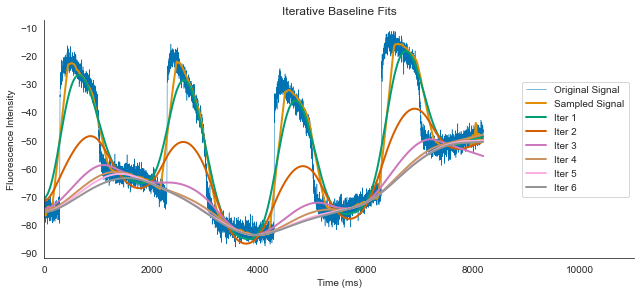

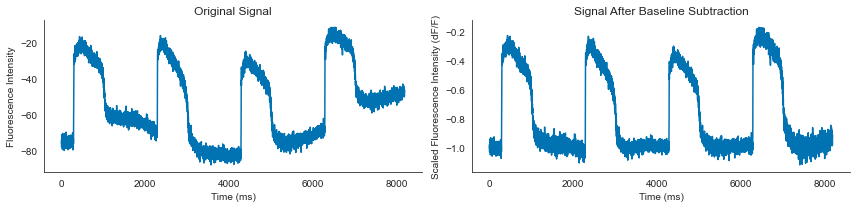

In [12]:
#Plot effect of baseline adjustment in sample trace 
adj_trace, to_plot  = base.baseline_adjust(all_traces[0])
plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
plt.plot(all_traces[0])
plt.title("Original Signal")
plt.xlabel("Time (ms)")
plt.ylabel("Fluorescence Intensity")
sns.despine()
plt.subplot(1,2,2)
plt.plot(adj_trace)
plt.title("Signal After Baseline Subtraction")
plt.xlabel("Time (ms)")
plt.ylabel("Scaled Fluorescence Intensity (dF/F)")
sns.despine()
plt.tight_layout()
plt.show()

# Remove Noise While Preserving Sharp AP Upstroke with Bilateral Filtering

In [13]:
class ClsBilateralFilter:
    '''
    Class that implements bilateral filtering on cardiac microtissue 
    spheroid fluorescence data after baseline adjustment.
    
    Bilateral filtering is intended to preserve sharp edges of the
    action potential upstrokes. The filter replaces each pixel value by a 
    normalized weighted average of surrounding pixel values 
    with largest weights assigned to nearby pixels with similar intensities.
    See Paris et al, 2008, Computer Graphics and Vision,
    doi:10.1561/0600000020, 6-10.
    
    Attributes
    -----------
    window_size: int
        number of neighbor pixels to include in weighted average
    sigma_s: float
        parameter determine the width of the Gaussian used 
        for spatial weighting
    sigma_i: float
        parameter determine the width of the Gaussian used 
        for intensity weighting
    sigma_i_weight: float
        if sigma_i is not pre-set, this is used to set the 
        width of the Gaussian used for intensity weighting
        as a multiple of sigma_s
    n_iters: int
        number of times to apply the filter 
    dist_filter: 1D float array
        spatial weights
    data: 1D float array
        input fluorescence signal 
    
    Methods
    --------
    make_distance_filter(self):
        Creates distance-based (Gaussian) filter
    filter_data(self):
        Executes bilateral filtering
    filter_pipeline(self, data):
        Applies bilateral filter to input data
    '''
    
    def __init__(self, window_size = 13, sigma_s = 0.3,
                 sigma_i = 0, sigma_i_weight = 1000, n_iters = 1):
        self.window_size = window_size  
        
        if np.any(sigma_s):
            self.sigma_s = sigma_s
            self.spatial_sd = -0.5/(self.sigma_s**2)
        else: #set automatically
            self.sigma_s = 0.5 - self.window_size/2
            self.spatial_sd = np.log(0.01)/self.sigma_s**2
            
        if np.any(sigma_i):
            self.sigma_i = sigma_i
        else: #set automatically
            self.sigma_i = self.sigma_s*sigma_i_weight
        self.i_sd = -0.5/(self.sigma_i**2)
            
        self.sigma_i_weight = sigma_i_weight
        self.n_iters = n_iters
    
    def make_distance_filter(self):
        '''
        Creates distance-based (Gaussian) filter
        '''
        n_size = self.window_size
        window_inds = np.arange(n_size) - (n_size - 1)/2
        filter_arr = np.exp(window_inds**2 * self.spatial_sd)
        self.dist_filter = filter_arr / np.sum(filter_arr)
        return
    
    def filter_data(self):
        '''
        Executes bilateral filtering 
        
        Returns
        --------
        output: 1D array of floats
            bilateral filtered trace
        '''
        win_size = self.window_size
        win_half = int(win_size/2)
        n = np.size(self.data)
        
        #allocate space to track averages & normalization factors
        temp = np.zeros(n)
        norm_factor = np.zeros(n)
        #combine distance filter with intensity-weighting
        for dist_idx in range(win_size - 1):
            s_input = np.roll(self.data, dist_idx - win_half)
            diff = self.data - s_input
            i_filter = np.exp(diff**2 * self.i_sd)
            temp += self.dist_filter[dist_idx] * i_filter * s_input
            norm_factor += i_filter * self.dist_filter[dist_idx] 
            
        output = temp/norm_factor #normalize
        return output
    
    def filter_pipeline(self, data):
        '''
        Applies bilateral filter to input data n_iter times
        
        Parameters
        -----------
        data: 1D array of floats
            fluorescence signal data
        
        Returns
        --------
        filtered_data: 1D array of floats
            bilaterally filtered data with initial and trailing pixels removed
        '''
        self.data = data
        orig_max, orig_min = np.max(data), np.min(data)
        for i in range(self.n_iters):
            self.make_distance_filter()
            filtered_data = self.filter_data()[:-20]
            self.data = filtered_data
        return filtered_data

In [14]:
#Normalization function
def normalize(trace):
    return (trace - np.min(trace))/(np.max(trace)-np.min(trace))

In [15]:
#Normalize signal intensity and apply bilateral filter
bilat = ClsBilateralFilter()
bilat.__init__(window_size = 30, sigma_s = 5, sigma_i = 0, n_iters = 5)
normalized_traces = [normalize(tr) for tr in adjusted_traces]
filtered = [bilat.filter_pipeline(tr) for tr in normalized_traces]

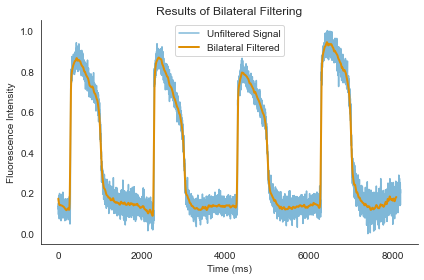

In [16]:
#Plot result of bilateral filtering
plt.plot(normalized_traces[0], label = 'Unfiltered Signal', alpha = 0.5)
plt.plot(filtered[0], label = 'Bilateral Filtered', linewidth = 2)
plt.legend()
plt.ylabel("Fluorescence Intensity")
plt.xlabel("Time (ms)")
plt.title("Results of Bilateral Filtering")
sns.despine()
plt.tight_layout()

# Automated Measurements of AP Metrics

In [17]:
class ClsAnalysis():
    '''
    A class used to analyze fluorescence recordings from one spheroid.
    Part of the image processing toolkit for cardiac microtissue experiments.
    The data fed to this class should already have been processed to remove baseline drift
    and filter noise.
    
    Attributes
    ----------
    max_num_peaks: int
        maximum number of action potentials (per cell)
    s_num_peaks: int
        number of action potentials detected (per cell)
    s_rep_type: int
        sets which algorithm is used to determine repolarization #TODO: describe these options more clearly
        0: percent ind
        1: moving average 
        2: moving average sub baseline  
    f_APD_crit: float
        percent repolarization to be calculated as start to search for APDmxr
    f_peak_crit: float
        percent of the fluorescence signal derivative that is set as the minimum threshold 
        for a detected action potential peak to be confirmed as a peak
    s_interpolate: int
        interpolation order, ie, the number of subdivisions of the x-axis (time) 
        for quadratic interpolation of the fluorescence signal derivative when 
        finding action potential peaks 
        
    i_ref_win_size: int
        sets size of window around a reference signal time
        used to search for action potential peaks
    i_ref_pos_win_size: int
        sets search window after a starting index
        used when finding action potential peaks
    i_ref_pre_win_size: int
        sets search window before a given index 
        used when finding action potential peaks, takeoff, repolarization, and decay time constant
    i_ref_rep_win_size: int
        sets search window around a given index
        used when finding action potential repolarization and decay 
    i_smooth_win_size_takeoff: int
        sets window size for smoothing function when finding action potential takeoff
    i_smooth_win_size_rep: int
        sets window size for smoothing function when finding action potential repolarization
    i_shift: int
        sets time shift from reference when analyzing action potential notches  #TODO: what's the notch for?
    f_scan_int: int
        scaling factor for time axis when fitting exponential function to find decay time constant
    i_ref_max_APD: int
        maximum action potential duration in ms
    repol_percs: list of floats
        repolarization thresholds to calculate 
    criteria: float
        Z-score threshold for finding AP upstrokes
    AP_peak_inds: 1D array of ints
        indices of action potential peaks 
    AP_peak_vals: 1D array of floats
        signal values at action potential peaks 
    AP_peak_deriv1_inds: 1D array of ints
        indices of action potential upstrokes (signal first derivative maximi)
    AP_peak_deriv1_vals: 1D array of floats
        signal first derivative values at action potential upstrokes (signal first derivative maximi)
    AP_repol_inds: 1D array of ints
        indices of final action potential repolarizations
    AP_repol_multi_inds: 2D array of ints
        indices of action potential repolarizations to different thresholds 
        specified by self.repol_percs
    AP_decays: 1D array of floats
        holds decay time constants of action potentials
    AP_repol_flags
        tracks whether or not a repolarization time was successfully found for each peak
        0 = unsuccessful
        1 = successful
    simulation: Boolean
        True if running algorithm on simulation rather than experimental data
    
    
    Methods
    ----------
    smooth(self, arr, width)
        Smooths signal using boxcar averaging method (analogous to low pass filter)
    get_first(self, mask, start, end)
        Find index of first 1 in a 1D array of 0s and 1s
    get_peak_window_Zscore(self, dfdt, arr_size, criteria, default_num)
        Finds windows containing action potential peaks using min & max thresholding criteria
        based on Z-scores of the fluorescence signal derivative
    find_peaks_ind(self)
        Get action potential peak upstroke indices & values using the first derivative
    check_threshold(self)
        Confirm that the action potential peak first derivative magnitudes are appropriately large
    find_max_peak(self)
        Find the action potential peaks using maximums of the fluorescence signal
    find_takeoff_local_max(self)
        Finds the start of each action potential ("action potential takeoff") and 
        the baseline immediately before takeoff.
    find_repol_mov_avg_sub(self)
        Finds time of repolarization for each action potential using moving average baseline subtraction
    find_repol_mov_avg_sub_baseline(self):
        Finds time of repolarization for each action potential using moving average baseline subtraction
    find_repol_deriv1(self)
        Find action potential repolarization time using the signal first derivative.
    find_repol_percent_ind(self)
        Find repolarization to the threshold percentage set by f_APD_crit using 
        signal amplitude
    find_multi_repol_perc_ind(self, repol_percs)
        Find times of repolarization to all threshold percentages in repol_percs list
    calc_asym_y(self, p, y, y_fit)
        Adjusts signal downwards for signal values that are greater than the 
        corresponding values from a fitted polynomial. Used in EAD detection routine.
    baseline_poly(self, p, y, n_max, iters, degree)
        Fits a polynomial to fluorescence signal baseline by iterating multiple times
        over y-data modified to reduce the signal values of largest magnitude.
        Used in EAD detection routine.
    fit_expo(self, x, y, a)
        Fits an exponential model. Used in decay time constant detection routine.    
    '''
    
    
    def __init__(self, max_num_peaks = 200, s_num_peaks = 0, 
                 s_rep_type = 1, peak_type = 0,
                 takeoff_type = 0, rise_type = 0,
                 f_APD_crit = 0.95,
                 f_peak_crit = 0.2, s_interpolate = 10, 
                 i_ref_win_size = 40, i_ref_pos_win_size = 40,
                 i_ref_pre_win_size = 40, i_ref_rep_win_size = 40,
                 i_smooth_win_size_takeoff = 100, i_smooth_win_size_rep = 41,
                 i_shift = 0, f_scan_int = 1, i_ref_max_APD = 5000,
                 repol_percs = [0.15, 0.25, 0.3, 0.5, 0.75, 0.9, 0.95, 1], criteria = 5,
                 simulation = True):
        self.max_num_peaks = max_num_peaks
        self.s_num_peaks = s_num_peaks
        self.s_repol_type = s_rep_type
        self.peak_type = peak_type
        self.takeoff_type = takeoff_type
        self.rise_type = rise_type
        self.f_APD_crit = f_APD_crit
        self.f_peak_crit = f_peak_crit
        self.s_interpolate = s_interpolate
        self.i_ref_win_size = i_ref_win_size
        self.i_ref_pos_win_size = i_ref_pos_win_size
        self.i_ref_pre_win_size = i_ref_pre_win_size
        self.i_ref_rep_win_size = i_ref_rep_win_size
        self.i_smooth_win_size_takeoff = i_smooth_win_size_takeoff
        self.i_smooth_win_size_rep = i_smooth_win_size_rep
        self.i_shift = i_shift
        self.f_scan_int = f_scan_int
        self.i_ref_max_APD = i_ref_max_APD
        self.repol_percs = repol_percs
        self.criteria = criteria
        self.simulation = simulation
        
    def smooth(self, arr, width):
        '''
        Smooths signal using boxcar averaging method (analogous to low pass filter)
        
        Parameters
        -----------
        arr: 1D array of floats
            signal data
        width: int
            window size over which to smooth
            
        Returns
        --------
        smooth_arr: 1D array of floats
            smoothed signal
        '''
        #ensure width is an even integer
        if width%2 == 0:
            width = width + 1 
        
        #take average along sequential windows
        half_width = int(width / 2)
        new_arr = [np.sum(arr[int(i - half_width):int(i + half_width + 1)]) 
                   for i in np.arange(half_width, len(arr)-width)]
        new_arr = np.array(new_arr) / (width - 1)
        
        #concatenate with original data at array edges
        smooth_arr = np.concatenate([arr[:half_width], new_arr, arr[int(len(arr)-width):]])
        return smooth_arr
  
        
    #Find index of first 1 in an array of 0s and 1s 
    def get_first(self, mask, start, end):
        '''
        Find index of first 1 in a 1D array of 0s and 1s
        
        Parameters 
        ----------
        mask: 1D numpy array
            array of 0s and 1s
        start: int
            start index of search window
        end: int
            end index of search window
            
        Returns
        --------
        int
            index of first 1 in array (-1 if array is all zeros)
        '''
        non_zeros = mask[start:end].nonzero()
        if np.any(non_zeros):
            return non_zeros[0][0] + start
        else:
            return -1
        

    def get_peak_window_Zscore(self, dfdt, arr_size, criteria, default_num):
        '''
        Finds windows containing action potential peaks using min & max thresholding criteria
        based on Z-scores of the fluorescence signal derivative.
        
        Parameters
        ----------
        dfdt: 1D array
            derivative of the fluorescence signal
        arr_size: int
            size of fluorescence signal 
        criteria: float
            minimum Z score above which to search for action potential peak
        default_num: int
            maximum number of peaks
            
        Returns 
        -------
        temp_arr: 2D array of size (2, default_num + 1)
            column 0 stores the total number of peaks
            all other columns correspond to action potential peaks
            row 0 stores the start index of the window containing the action potential peak
            row 1 stores the end index of the window containing the action potential peak
        '''
        peak_windows = np.zeros((2, default_num))
        num_peaks = 0
        #remove first and last small regions (intensity may not be stable)
        start_ind, end_ind = 10, arr_size - 10 

        #get Z-scores
        std = np.std(dfdt[start_ind:end_ind])
        z_scores = dfdt/std
        
        #Calculate upper and lower z-score thresholds
        crit_below = -criteria
        gt_crit = z_scores > criteria
        lt_crit = z_scores < crit_below
        
        #adjust thresholds 
        i = 1
        while np.sum(gt_crit) < 15 and i < 3:
            gt_crit = z_scores > criteria*(50-10*i)
            i += 1
            
        #print(np.sum(lt_crit))
        if np.sum(lt_crit) < np.sum(gt_crit) - 1:
            #print("readjusting lower cirt")
            lt_crit = z_scores < crit_below*0.8
            if np.sum(lt_crit) < np.sum(gt_crit) - 1:
                lt_crit = z_scores < crit_below*0.5
                if np.sum(lt_crit) < np.sum(gt_crit) - 1:
                    lt_crit = z_scores < crit_below*0.3

        while start_ind < arr_size and num_peaks < default_num:
            #Find next index where signal is greater than upper criteria 
            #This will be the start of the action potential peak window
            first = self.get_first(gt_crit, start_ind, end_ind)
            if first == -1:
                return peak_windows, num_peaks
            if first > start_ind:
                start_ind = first
                num_peaks += 1
                peak_windows[0, num_peaks - 1] = start_ind
                
                #Find next index where signal is less than the lower criteria 
                #This will be the end of the action potential peak window
                first = self.get_first(lt_crit, start_ind, end_ind)
            if first == -1:
                peak_windows[1, num_peaks - 1] = arr_size - 1
                return peak_windows, num_peaks
            if first == start_ind:
                start_ind = start_ind + 1
            else:
                start_ind = first
                peak_windows[1,num_peaks - 1] = start_ind
        
        return peak_windows, num_peaks
                
    def find_peaks_ind(self):
        '''
        Get action potential peak indices & values using the first derivative
        Stores indices in self.AP_peak_deriv1_inds
        Stores corresponding values of fluorescence signal derivative in self.AP_peak_deriv1_vals
        '''
        peak_windows, num_peaks = self.get_peak_window_Zscore(self.deriv1, arr_size = self.i_num_frames,
                                              criteria = self.criteria, default_num = self.max_num_peaks)
        peak_windows = peak_windows.astype(int)
        self.s_num_peaks = int(num_peaks)
        
        if num_peaks > 0:
            smoothed_deriv = np.diff(self.smooth(self.data, 100))
            
            self.AP_peak_deriv1_inds = np.zeros(num_peaks)
            self.AP_peak_deriv1_vals = np.zeros(num_peaks)
            
            for i in range(num_peaks):
                ind_max = np.argmax(smoothed_deriv[peak_windows[0,i]:peak_windows[1,i]])
                self.AP_peak_deriv1_inds[i] = peak_windows[0,i] + ind_max
            self.AP_peak_deriv1_inds = self.AP_peak_deriv1_inds.astype(int)
            self.AP_peak_deriv1_vals = self.deriv1[self.AP_peak_deriv1_inds]
        return
    
    def check_threshold(self):
        '''
        Confirm that action potential first derivative peaks are appropriately large
        '''
        n_peaks = self.s_num_peaks
        v_deriv_max = np.max(self.deriv1)
        peak_crit = self.f_peak_crit * v_deriv_max
        bad_ind = np.where(self.AP_peak_deriv1_vals[0:n_peaks-1] < peak_crit)
        if not np.any(bad_ind):
            return
        self.AP_peak_deriv1_inds[bad_ind] = -1
        return
    
    def find_max_peak(self):
        '''
        Find the action potential peak maximums using the fluorescence signal (NOT the derivative)
        Store indices in self.AP_peak_inds and corresponding signal values in self.AP_peak_vals
        '''
        n_peaks = self.s_num_peaks
        
        if self.s_num_peaks > 0:
            self.AP_peak_inds = np.zeros(n_peaks)
            self.AP_peak_vals = np.zeros(n_peaks)
            
            for i in range(self.s_num_peaks):
                #Set search window starting from the indices found using the 
                #first derivative criteria
                ref_ind = self.AP_peak_deriv1_inds[i]
                start_ind = ref_ind
                end_ind = ref_ind + 2*self.i_ref_win_size
                if start_ind < 0:
                    start_ind = 0
                if end_ind >= self.i_num_frames:
                    end_ind = self.i_num_frames - 1
                    
                ind_max = np.argmax(self.data[start_ind:end_ind])
                
                self.AP_peak_inds[i] = ind_max + start_ind 

                
            self.AP_peak_inds = self.AP_peak_inds.astype(int)
            self.AP_peak_vals = self.data[self.AP_peak_inds]

        
        return 
    
    def find_peak_deriv2(self):
        n_peaks = self.s_num_peaks
       
        if self.s_num_peaks > 0:
            self.AP_peak_inds = np.zeros(n_peaks)
            self.AP_peak_vals = np.zeros(n_peaks)
           
            deriv2 = np.diff(np.diff(self.smooth(self.data, width = 40)))
       
            #Do not include the final peak
            for i in range(self.s_num_peaks):
                #Set search window starting from the indices found using the
                #first derivative criteria
                ref_ind = self.AP_peak_deriv1_inds[i]
                start_ind = ref_ind - self.i_ref_win_size
                end_ind = ref_ind + 2*self.i_ref_win_size
                if start_ind < 0:
                    start_ind = 0
                if end_ind >= self.i_num_frames:
                    end_ind = self.i_num_frames - 1
                   
                ind_min = np.argmin(deriv2[start_ind:end_ind])
                self.AP_peak_inds[i] = ind_min + start_ind
               
            self.AP_peak_inds = self.AP_peak_inds.astype(int)
            self.AP_peak_vals = self.data[self.AP_peak_inds]
        return
        
    def find_takeoff_deriv2(self):
        '''
        Finds the start of each action potential ("action potential takeoff")
        using the 2nd derivative maximum. Baseline indices and values are
        stored in self.AP_takeoff_baseline_inds and self.AP_takeoff_baseline_vals
        '''    
        if self.s_num_peaks > 0:
       
            self.AP_takeoff_baseline_inds = np.zeros(self.s_num_peaks)
            self.AP_takeoff_baseline_vals = np.zeros(self.s_num_peaks)
           
            deriv2 = self.deriv2
           
            for i in range(self.s_num_peaks):
                #set search window before action potential peak chosen by 1st derivative
                ref = self.AP_peak_deriv1_inds[i]
                start_ind = ref - self.i_smooth_win_size_takeoff
                end_ind = ref
                if start_ind < 0:
                    start_ind = 0
                   
                #find takeoff value: maximum of 2nd derivative
                ind = np.argmax(deriv2[start_ind:end_ind])
                if ind == 0:
                    ind = ind + 1
                takeoff_ind = int(ind + start_ind)
               
                self.AP_takeoff_baseline_inds[i] = takeoff_ind
                self.AP_takeoff_baseline_vals[i] = self.data[takeoff_ind]
       
        return
    
    def find_takeoff_local_max(self):
        '''
        Finds the start of each action potential ("action potential takeoff") and 
        the baseline immediately before takeoff. Baseline indices and values are 
        stored in self.AP_takeoff_baseline_inds and self.AP_takeoff_baseline_vals
        '''    
        self.i_smooth_win_size_takeoff = 5
        if self.s_num_peaks > 0:
            local_sub_raw = self.smooth(self.data, self.i_smooth_win_size_takeoff) - self.data
            
            self.AP_takeoff_baseline_inds = np.zeros(self.s_num_peaks)
            self.AP_takeoff_baseline_vals = np.zeros(self.s_num_peaks)
            
            for i in range(self.s_num_peaks):
                #set search window before action potential peak chosen by 1st derivative
                ref = self.AP_peak_deriv1_inds[i]
                start_ind = ref - self.i_smooth_win_size_takeoff
                end_ind = ref 
                if start_ind < 0:
                    start_ind = 0
                    
                #find takeoff value: greatest negative deviation from the smoothed signal
                ind = np.argmax(local_sub_raw[start_ind:end_ind])
                if ind == 0:
                    ind = ind + 1
                takeoff_ind = int(ind + start_ind)
                self.AP_takeoff_baseline_inds[i] = takeoff_ind
                self.AP_takeoff_baseline_vals[i] = self.data[takeoff_ind]

        
        return

    
    def find_repol_mov_avg_sub(self):
        '''
        Finds time of repolarization for each action potential using 
        moving average baseline subtraction. Indices stored in 
        self.AP_repol_inds.
        '''
        n_peaks = self.s_num_peaks
        local_sub_raw = self.smooth(self.data, self.i_smooth_win_size_rep) - self.data

        #Calculate rough recovery thresholds for each peak
        crit = (self.AP_peak_vals - self.AP_takeoff_baseline_vals)*(1 - 0.75)#self.f_APD_crit) 
        crit += self.AP_takeoff_baseline_vals
        
        #Allocate space, excluding final peak
        self.AP_repol_flags = np.zeros(self.s_num_peaks - 1)
        self.AP_repol_inds = np.zeros(self.s_num_peaks - 1)
        self.AP_repol_vals = np.zeros(self.s_num_peaks - 1)
        
        #Remove last peak
        for i in range(self.s_num_peaks - 1):
            #Set search window between action potential peak and next action potential takeoff
            start_ind = self.AP_peak_inds[i] + self.i_ref_pos_win_size 
            if i == self.s_num_peaks - 1:
                end_ind = self.i_num_frames - 1
            else:
                end_ind = self.AP_takeoff_baseline_inds[i + 1] - self.i_smooth_win_size_rep
            if end_ind < 0:
                end_ind = self.i_num_frames - 1
            if end_ind > self.AP_peak_deriv1_inds[i] + self.i_ref_max_APD:
                end_ind = self.AP_peak_deriv1_inds[i] + self.i_ref_max_APD
            if end_ind < start_ind:
                start_ind = end_ind - self.i_ref_pre_win_size
            if start_ind < 0:
                start_ind = 0
            start_ind, end_ind = int(start_ind), int(end_ind)
            
            #Find first time signal falls below rough recovery threshold
            data_arr = self.data[start_ind:end_ind]
            flags = data_arr < crit[i]
            first = self.get_first(flags, 0, end_ind - start_ind)
            if first == -1:
                adj_start_ind = start_ind
            else:
                adj_start_ind = start_ind + first
            
            #Set repolarization index at the maximum of negative signal deviation 
            #from smoothed signal after rough recovery threshold
            ind = np.argmax(local_sub_raw[adj_start_ind:end_ind]) #end_ind])
            self.AP_repol_inds[i] = ind + adj_start_ind
            
            #Flag to confirm repolarization index is under 90% repolarization threshold
            f_base = self.AP_takeoff_baseline_vals[i]
            crit_rep = 0.9*(self.AP_peak_vals[i] - f_base) + f_base
            if self.data[ind + adj_start_ind] < crit_rep:
                self.AP_repol_flags[i] = 1
            
        self.AP_repol_inds = self.AP_repol_inds.astype(int)
        self.AP_repol_vals = self.data[self.AP_repol_inds]
        
        return
    
    def find_repol_deriv2(self):
        '''
        Find repolarization using the local maximum of the 2nd derivative.
        Results are stored in self.AP_repol_inds.
        '''
        #allocate space to store results
        self.AP_repol_inds = np.zeros(self.s_num_peaks - 1)
        self.AP_repol_vals = np.zeros(self.s_num_peaks - 1)
       
        deriv2 = self.deriv2 
       
       
        #Remove last action potential
        for i in range(self.s_num_peaks - 1):
            #set search window based on peak & action potential takeoff
            start_ind = self.AP_peak_inds[i] + self.i_ref_pre_win_size
            if i < self.s_num_peaks - 1:
                end_ind = self.AP_takeoff_baseline_inds[i+1] - self.i_ref_pre_win_size
            else:
                end_ind = self.i_num_frames - 1
           
            if end_ind < start_ind:
                self.AP_repol_inds[i] = 0
            else:
                start_ind, end_ind = int(start_ind), int(end_ind)
                repol_ind = np.argmax(deriv2[start_ind:end_ind])
   
                if repol_ind == start_ind:
                    repol_ind = end_ind
                self.AP_repol_inds[i] = repol_ind + start_ind + 2 #2 to correct for derivative-taking shift
        self.AP_repol_inds = self.AP_repol_inds.astype(int)
        self.AP_repol_vals[0:self.s_num_peaks - 1] = self.data[self.AP_repol_inds[0:self.s_num_peaks-1]]
       
        return
    
    def find_repol_percent_ind(self):
        '''
        Find repolarization to the threshold percentage set by f_APD_crit using 
        signal amplitude. Results are stored in self.AP_repol_inds. 
        '''
        crit = (self.AP_peak_vals - self.AP_takeoff_baseline_vals)*(1 - self.f_APD_crit) 
        crit += self.AP_takeoff_baseline_vals
        
        #allocate space to store results
        self.AP_repol_flags = np.zeros(self.s_num_peaks - 1)
        self.AP_repol_inds = np.zeros(self.s_num_peaks - 1)
        self.AP_repol_vals = np.zeros(self.s_num_peaks - 1)
        
        #Remove last action potential
        for i in range(self.s_num_peaks - 1):
            #set search window based on peak & action potential takeoff
            start_ind = self.AP_peak_inds[i] + self.i_ref_pre_win_size
            if i < self.s_num_peaks - 1:
                end_ind = self.AP_takeoff_baseline_inds[i+1] - self.i_ref_pre_win_size
            else:
                end_ind = self.i_num_frames - 1
            
            if end_ind < start_ind:
                self.AP_repol_inds[i] = 0
            else:
                start_ind, end_ind = int(start_ind), int(end_ind)
                #find first time signal repolarizes to less than the criteria threshold
                data_arr = self.data[start_ind:end_ind]
                mask = data_arr < crit[i]
                first = self.get_first(mask, 0, len(mask))
                if first != -1:
                    self.AP_repol_inds[i] = first + start_ind
                    self.AP_repol_flags[i] = 1
                else:
                    self.AP_repol_inds[i] = end_ind
        self.AP_repol_inds = self.AP_repol_inds.astype(int)
        self.AP_repol_vals[0:self.s_num_peaks - 1] = self.data[self.AP_repol_inds[0:self.s_num_peaks-1]]
    
        return 
        
        
    def find_multi_repol_perc_ind(self):
        '''
        Find times of repolarization to all threshold percentages in repol_percs list.
        Results are stored in self.AP_repol_multi_inds and returned as temp_rec. 
        
        Returns 
        --------
        temp_rec: 2D numpy array (len(self.repol_percs) x self.s_num_peaks - 1)
            holds times of repolarizations to each repolarization threshold in self.repol_percs
            columns represent different action potentials
            rows represent different repolarization thresholds, in order of self.repol_percs
        '''
        n_peaks = self.s_num_peaks
        
        self.AP_repol_multi_inds = np.zeros((len(self.repol_percs), self.s_num_peaks - 1))
        
        #TODO: should be a faster way to do this with arrays
        for repol_idx, repol_perc in enumerate(self.repol_percs):
            crit = (self.AP_peak_vals - self.AP_takeoff_baseline_vals)*(1-repol_perc) + self.AP_takeoff_baseline_vals
            #ignore last action potential
            for i in range(self.s_num_peaks - 1):
                #set search window 
                start_ind = self.AP_peak_inds[i] + self.i_ref_pre_win_size
                if i < self.s_num_peaks - 1:
                    end_ind = self.AP_takeoff_baseline_inds[i+1] - self.i_ref_pre_win_size
                else:
                    end_ind = self.i_num_frames - 1
                    
                #find first time amplitude repolarizes under threshold criteria
                if end_ind > start_ind:
                    start_ind, end_ind = int(start_ind), int(end_ind)
                    
                    data_arr = self.data[start_ind:end_ind]
                    first = self.get_first(data_arr < crit[i], 0, end_ind - start_ind)
                    if first == -1:
                        #if fails to repolarize in window, return minimum signal index
                        min_ind = np.argmin(data_arr)
                        self.AP_repol_multi_inds[repol_idx, i] = min_ind + start_ind
                    else:
                        self.AP_repol_multi_inds[repol_idx, i] = start_ind + first
                else:
                    self.AP_repol_multi_inds[repol_idx, i] = 0
                        
        temp_rec = self.AP_repol_multi_inds
        return temp_rec

        
    def calc_asym_y(self, p, y, y_fit):
        '''
        Adjusts signal downwards for signal values that are greater than the 
        corresponding values from a fitted polynomial.
        Used in EAD detection routine.
        
        Parameters
        -----------
        p: float
            percent of the difference between y and y_fit 
            by which to adjust y values greater than y_fit
        y: 1D array of floats
            ordinate variable data
        y_fit: 1D array of floats
            ordinate variable data calculated from a polynomial fitted to y
        
        Returns
        --------
        y_res: 1D array of floats
            y-data decreased by (1-p) percent of the difference between y & y_fit
            for all values where y was greater than y_fit        
        '''
        diff_y = y - y_fit
        crit = diff_y > 0
        y_res = y - (1-p)*crit*diff_y
        return y_res
    
    def baseline_poly(self, p, y, n_max, iters, degree):
        '''
        Fits a polynomial to fluorescence signal baseline by iterating multiple times
        over y-data modified to reduce the signal values of largest magnitude.
        
        Parameters
        ----------
        p: float
            used in calc_asym_y as the percent of the difference between y and y_fit
            by which to adjust y values greater than y_fit
        y: 1D array of floats
            data to fit
        n_max: int
            maximum length of signal to fit 
        iters: int
            number of iterations that... #TODO figure that out
        degree: int
            polynomial degree
            
        Returns 
        --------
        y_fit: 1D array of floats
            fitted signal baseline
        '''
        #constrain signal length
        n = np.size(y)
        if n > n_max:
            y_reduced = np.resize(y, n_max)
            y_reduced = y[::int(n/n_max)][:n_max]
            i_comp_flag = 1
        else:
            y_reduced= y 
            i_comp_flag = 0
        n_reduced = np.size(y_reduced)
        
        #fit polynomial over multiple iterations,
        #reducing greatest y values with each iteration
        x = np.arange(n_reduced)
        poly_fit = Polynomial.fit(x, y_reduced, degree)
        y_fit = poly_fit(x)
        for i in range(iters):
            y_res = self.calc_asym_y(p, y_reduced, y_fit)
            poly_fit = Polynomial.fit(x, y_res, degree)
            y_fit = poly_fit(x)
            
        #resize to original signal length
        if i_comp_flag == 1:
            y_fit = scipy.ndimage.interpolation.zoom(y_fit, n/len(y_fit)) 
        return y_fit
        

        
    def fit_expo(self, x, y, a):
        '''
        Fits an exponential model (constant raised to the xth power).
        Used in decay time constant detection routine.
        
        Parameters
        -----------
        x: 1D array of floats
            abscissa variable data
        y: 1D array of floats
            ordinate variable data
        a: list of floats, length 3
            initial guesses for model coefficients
            
        Returns
        --------
        popt: list of floats, length 3
            fitted model coefficients
        '''
        def f_expo(a0, a1, a2, x):
            return a0*a1**x + a2
        
        popt, pcov = scipy.optimize.curve_fit(f_expo, x, y, p0 = a)
        return popt


    
    def set_data(self, filtered_data):
        '''
        Loads data and calculates relevant parameters to enable analysis
        
        Parameters
        -----------
        filtered_data: 1D array of floats
            signal fluorescence data filtered as described above
        '''
        self.data = filtered_data
        self.has_data = 1
        self.i_num_frames= np.size(filtered_data)
        self.deriv1 = np.diff(filtered_data)
        self.pderiv2 = np.diff(self.deriv1)
        self.deriv2 = np.diff(np.diff(self.smooth(self.data, width = 40)))
        return
    
    
    def fit_expo(self, x, y, a):
        '''
        Fits an exponential model (constant raised to the xth power).
        Used in decay time constant detection routine.
        
        Parameters
        -----------
        x: 1D array of floats
            abscissa variable data
        y: 1D array of floats
            ordinate variable data
        a: list of floats, length 3
            initial guesses for model coefficients
            
        Returns
        --------
        popt: list of floats, length 3
            fitted model coefficients
        '''
        def f_expo(a0, a1, a2, x):
            return a0*np.exp(a1*x) + a2
        
        y = self.rescale_image(y)
        
        popt, pcov = scipy.optimize.curve_fit(f_expo, x, y,
                                             p0 = [-1, 0.005, 250],
                                             bounds = [[-100, 0, 0],
                                                       [0,0.005, 260]])
        #bounds = [[-np.inf, -np.inf, -np.inf],[0, np.inf, np.inf]])
        print("coefficients: ", popt)
        plt.figure()
        plt.title("data being fit")
        plt.plot(x,y)
        plt.plot(x, f_expo(popt[0], popt[1], popt[2], x), color = 'red')
        plt.ylim(0,250)
        plt.show()
        
        return popt
    
    def find_risetime_deriv2(self):
        #allocate space
        self.AP_rise_times = np.zeros(self.s_num_peaks - 1)
       
        #calculate second derivative
        deriv2 = self.deriv2
       
        #Remove last peak
        for i in range(self.s_num_peaks - 1):
            #Set search window before takeoff and after peak
            start_ind = int(self.AP_takeoff_baseline_inds[i] - 100)
            end_ind = self.AP_peak_inds[i] + 100
            if end_ind > self.i_num_frames:
                end_ind = self.i_num_frames - 1
            if start_ind < 0:
                start_ind = 0
               
            #Find difference between 2nd derivative max and min around AP takeoff
            deriv_arr = deriv2[start_ind:end_ind]
            min_ind, max_ind = np.argmin(deriv_arr) + start_ind, np.argmax(deriv_arr) + start_ind
            if max_ind < min_ind:
                self.AP_rise_times[i] = min_ind - max_ind
            else:
                print("ERROR WITH RISE TIME")     
        return 
    
    def find_risetime_subtr(self):
        self.AP_rise_times = self.AP_peak_inds - self.AP_takeoff_baseline_inds
        return
    
    
    def find_risetime(self):
        if self.rise_type == 0:
            self.find_risetime_subtr()
        else:
            self.find_risetime_deriv2()
        return
    
    def find_takeoff(self):
        '''Find AP takeoff according to method specified by self.peak_type'''
        if self.takeoff_type == 0:
            self.find_takeoff_local_max()
        else:
            self.find_takeoff_deriv2()
        return
    
    def find_peak(self):
        '''Find AP peak according to method specified by self.peak_type'''
        if self.peak_type == 0:
            self.find_max_peak()
        else:
            self.find_peak_deriv2()
            
    def find_repolarization(self):
        '''
        Find action potential repolarization times using 
        self.s_repol_type to determine method.
        '''
        if self.s_repol_type == 0:
            self.find_repol_percent_ind()
        elif self.s_repol_type == 1:
            self.find_repol_mov_avg_sub()
        else:
            self.find_repol_deriv2()
        return 
    
    def analyze(self):
        '''
        Obtain metrics
        '''
        self.find_peaks_ind()
        self.find_peak()
        self.find_takeoff()
        self.find_repolarization()
        self.find_multi_repol_perc_ind()
        self.find_risetime()
        
        if self.sNaN:
            self.check_threshold()
        return 

In [18]:
#
analyze_MA = ClsAnalysis(s_rep_type = 1, takeoff_type = 0, peak_type = 0, 
                          criteria = 1.3, i_ref_max_APD = 1000, 
                         i_ref_win_size = 500, i_ref_pos_win_size  = 50, f_APD_crit = 0.95,
                          repol_percs = [0.3, 0.5, 0.8],
                         i_smooth_win_size_takeoff = 100)

analysis_dict_MA = {}
cell_idx = -1
for f in filtered[1:]:
    cell_idx += 1
    analyze_MA.set_data(f)
    analyze_MA.sNaN = False
    analyze_MA.analyze()
    
    #get metrics from the second last AP in each spheroid's trace
    AP_start = analyze_MA.AP_takeoff_baseline_inds[-2]
    APD_subs = [row[-1] - AP_start for row in analyze_MA.AP_repol_multi_inds]
    
    APD30, APD50, APD80 = APD_subs[0], APD_subs[1], APD_subs[2]
    APD_mxr = analyze_MA.AP_repol_inds[-1] - AP_start
    rise_time = analyze_MA.AP_rise_times[-1]

    analysis_dict_MA[cell_idx] = [APD30, APD50, APD80, APD_mxr, rise_time]

In [19]:
#Display metrics obtained for each spheroid
results_df = pd.DataFrame(analysis_dict_MA).T
results_df.columns = ['APD30', 'APD50', 'APD80', 'APD_mxr', 'rise_time']
results_df

,APD30,APD50,APD80,APD_mxr,rise_time
0,569.0,723.0,772.0,791.0,50.0
1,399.0,662.0,779.0,832.0,50.0
2,494.0,706.0,767.0,793.0,51.0
3,267.0,400.0,579.0,552.0,54.0
4,249.0,369.0,556.0,549.0,53.0
5,551.0,683.0,728.0,746.0,53.0
